In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO, DQN
from gymnasium.wrappers import RecordVideo
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecVideoRecorder
import os 
import do_mpc
from casadi import vertcat

## Specify the models and train them

In [9]:
rl_train_steps = 100000

# Create 'Results' folder if it doesn't exist
results_folder = "Results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Train PPO model
#------------------------------------------------------------------------------------------------------------------------------------------------
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
ppo_model = PPO("MlpPolicy", env, verbose=1)
ppo_model.learn(total_timesteps=rl_train_steps)
ppo_model.save(os.path.join(results_folder, "ppo_cartpole_model_training_steps_" + str(rl_train_steps)))  # Save PPO model
env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Train DQN model
#------------------------------------------------------------------------------------------------------------------------------------------------
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
dqn_model = DQN("MlpPolicy", env, verbose=1)
dqn_model.learn(total_timesteps=rl_train_steps)
dqn_model.save(os.path.join(results_folder, "dqn_cartpole_model_training_steps_" + str(rl_train_steps)))  # Save PPO model

env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Specify the MPC model
#------------------------------------------------------------------------------------------------------------------------------------------------
class MPCController:
    def __init__(self, horizon=10, dt=0.02, recompute_every=1):
        self.horizon = horizon  # Prediction steps
        self.dt = dt  # Time step
        self.recompute_every = recompute_every  # How often to recompute optimal actions
        self.force_mag = 10.0
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.length = 0.5  # Half-length of pole
        self.total_mass = self.masscart + self.masspole
        self.polemass_length = self.masspole * self.length

        # Define model
        model_type = "continuous"
        self.model = do_mpc.model.Model(model_type)
        
        x = self.model.set_variable(var_type='_x', var_name='x', shape=(1,1))
        x_dot = self.model.set_variable(var_type='_x', var_name='x_dot', shape=(1,1))
        theta = self.model.set_variable(var_type='_x', var_name='theta', shape=(1,1))
        theta_dot = self.model.set_variable(var_type='_x', var_name='theta_dot', shape=(1,1))
        u = self.model.set_variable(var_type='_u', var_name='u', shape=(1,1))
        
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        temp = (u + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        
        self.model.set_rhs('x', x_dot)
        self.model.set_rhs('x_dot', xacc)
        self.model.set_rhs('theta', theta_dot)
        self.model.set_rhs('theta_dot', thetaacc)
        
        self.model.setup()
        
        # Define MPC controller
        self.mpc = do_mpc.controller.MPC(self.model)
        setup_mpc = {
            'n_horizon': self.horizon,
            't_step': self.dt,
            'n_robust': 0,
            'state_discretization': 'collocation',
            'collocation_type': 'radau',
            'collocation_deg': 2,
            'collocation_ni': 1,
            'store_full_solution': False,
        }
        self.mpc.set_param(**setup_mpc)
        
        self.mpc.set_objective(mterm=theta**2 + x**2, lterm=theta**2 + x**2 + 0.01*u**2)
        self.mpc.bounds['lower','_u','u'] = -self.force_mag
        self.mpc.bounds['upper','_u','u'] = self.force_mag
        
        self.mpc.setup()

    def get_action(self, obs):
        self.mpc.x0 = np.array(obs).reshape(-1, 1)
        self.mpc.set_initial_guess()
        u_opt = self.mpc.make_step(self.mpc.x0)
        return float(u_opt[0])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | 24.4     |
| time/              |          |
|    fps             | 1969     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 26.2         |
|    ep_rew_mean          | 26.2         |
| time/                   |              |
|    fps                  | 1212         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0077524153 |
|    clip_fraction        | 0.0761       |
|    clip_range           | 0.2          |
|    en

## Multiple episodes

In [ ]:
SEED = 42

# Create 'Results' folder if it doesn't exist
results_folder = "Results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    
# Load PPO model
ppo_model = PPO.load(os.path.join(results_folder, "ppo_cartpole_model_training_steps_" + str(rl_train_steps)))  # Save PPO model
print("Loaded PPO model:", ppo_model)

# Load DQN model
dqn_model = DQN.load(os.path.join(results_folder, "dqn_cartpole_model_training_steps_" + str(rl_train_steps)))  # Save PPO model
print("Loaded DQN model:", dqn_model)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Evaluate PPO model with multiple episodes and save episode lengths
#------------------------------------------------------------------------------------------------------------------------------------------------
ppo_episode_lengths = []
num_episodes = 5

for episode in range(num_episodes):
    test_env = gym.make("CartPole-v1", render_mode="rgb_array")
    video_filename = f"Results/ppo_test_video/rl_training_steps_{rl_train_steps}episode_{episode + 1}.mp4"
    test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda episode_id: True)

    done = False
    obs, _ = test_env.reset(seed=SEED+episode)
    episode_length = 0
    while not done and episode_length < 500:
        action, _states = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = test_env.step(action)
        episode_length += 1
    
    ppo_episode_lengths.append(episode_length)
    print(f"PPO Episode {episode + 1} finished with length: {episode_length}")
    test_env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Evaluate DQN model with multiple episodes and save episode lengths
#------------------------------------------------------------------------------------------------------------------------------------------------
dqn_episode_lengths = []

for episode in range(num_episodes):
    test_env = gym.make("CartPole-v1", render_mode="rgb_array")
    video_filename = f"Results/dqn_test_video/rl_training_steps_{rl_train_steps}_episode_{episode + 1}.mp4"
    test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda episode_id: True)

    done = False
    obs, _ = test_env.reset(seed=SEED+episode)
    episode_length = 0
    while not done and episode_length < 500:
        action, _states = dqn_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = test_env.step(action)
        episode_length += 1
    
    dqn_episode_lengths.append(episode_length)
    print(f"DQN Episode {episode + 1} finished with length: {episode_length}")
    test_env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Evaluate MPC model with horizon = 10 and recompute_every = 1
#------------------------------------------------------------------------------------------------------------------------------------------------
mpc_episode_lengths_h_10_e_1 = []
horizon = 10
recompute_every = 1
mpc = MPCController(horizon=horizon, recompute_every=recompute_every)

for episode in range(num_episodes):
    test_env = gym.make("CartPole-v1", render_mode="rgb_array")
    video_filename = f"Results/mpc_test_video/episode_{episode + 1}_horizon_{horizon}_recompute_{recompute_every}.mp4"
    test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda episode_id: True)

    done = False
    obs, _ = test_env.reset(seed=SEED+episode)
    episode_length = 0
    step = 0
    while not done and episode_length < 500:
        if step % mpc.recompute_every == 0:
            action = 1 if mpc.get_action(obs) > 0 else 0  # Convert continuous force to discrete action
        obs, reward, done, truncated, info = test_env.step(action)
        step += 1
        episode_length += 1

    mpc_episode_lengths_h_10_e_1.append(episode_length)
    print(f"MPC Episode {episode + 1} finished with length: {episode_length}")
    test_env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Evaluate MPC model with horizon = 10 and recompute_every = 5
#------------------------------------------------------------------------------------------------------------------------------------------------
mpc_episode_lengths_h_10_e_5 = []
horizon = 10
recompute_every = 5
mpc = MPCController(horizon=horizon, recompute_every=recompute_every)

for episode in range(num_episodes):
    test_env = gym.make("CartPole-v1", render_mode="rgb_array")
    video_filename = f"Results/mpc_test_video/episode_{episode + 1}_horizon_{horizon}_recompute_{recompute_every}.mp4"
    test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda episode_id: True)

    done = False
    obs, _ = test_env.reset(seed=SEED+episode)
    episode_length = 0
    step = 0
    while not done and episode_length < 500:
        if step % mpc.recompute_every == 0:
            action = 1 if mpc.get_action(obs) > 0 else 0  # Convert continuous force to discrete action
        obs, reward, done, truncated, info = test_env.step(action)
        step += 1
        episode_length += 1

    mpc_episode_lengths_h_10_e_5.append(episode_length)
    print(f"MPC Episode {episode + 1} finished with length: {episode_length}")
    test_env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Evaluate MPC model with horizon = 50 and recompute_every = 1
#------------------------------------------------------------------------------------------------------------------------------------------------
mpc_episode_lengths_h_50_e_1 = []
horizon = 50
recompute_every = 1
mpc = MPCController(horizon=horizon, recompute_every=recompute_every)

for episode in range(num_episodes):
    test_env = gym.make("CartPole-v1", render_mode="rgb_array")
    video_filename = f"Results/mpc_test_video/episode_{episode + 1}_horizon_{horizon}_recompute_{recompute_every}.mp4"
    test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda episode_id: True)

    done = False
    obs, _ = test_env.reset(seed=SEED+episode)
    episode_length = 0
    step = 0
    while not done and episode_length < 500:
        if step % mpc.recompute_every == 0:
            action = 1 if mpc.get_action(obs) > 0 else 0  # Convert continuous force to discrete action
        obs, reward, done, truncated, info = test_env.step(action)
        step += 1
        episode_length += 1

    mpc_episode_lengths_h_50_e_1.append(episode_length)
    print(f"MPC Episode {episode + 1} finished with length: {episode_length}")
    test_env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Evaluate MPC model with horizon = 50 and recompute_every = 5
#------------------------------------------------------------------------------------------------------------------------------------------------
mpc_episode_lengths_h_50_e_5 = []
horizon = 50
recompute_every = 5
mpc = MPCController(horizon=horizon, recompute_every=recompute_every)

for episode in range(num_episodes):
    test_env = gym.make("CartPole-v1", render_mode="rgb_array")
    video_filename = f"Results/mpc_test_video/episode_{episode + 1}_horizon_{horizon}_recompute_{recompute_every}.mp4"
    test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda episode_id: True)

    done = False
    obs, _ = test_env.reset(seed=SEED+episode)
    episode_length = 0
    step = 0
    while not done and episode_length < 500:
        if step % mpc.recompute_every == 0:
            action = 1 if mpc.get_action(obs) > 0 else 0  # Convert continuous force to discrete action
        obs, reward, done, truncated, info = test_env.step(action)
        step += 1
        episode_length += 1

    mpc_episode_lengths_h_50_e_5.append(episode_length)
    print(f"MPC Episode {episode + 1} finished with length: {episode_length}")
    test_env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Save episode lengths to file (optional)
np.savetxt("Results/ppo_episode_lengths.csv", ppo_episode_lengths, delimiter=",")
np.savetxt("Results/dqn_episode_lengths.csv", dqn_episode_lengths, delimiter=",")
np.savetxt("Results/mpc_episode_lengths.csv", mpc_episode_lengths_h_10_e_1, delimiter=",")
np.savetxt("Results/mpc_episode_lengths.csv", mpc_episode_lengths_h_50_e_1, delimiter=",")
np.savetxt("Results/mpc_episode_lengths.csv", mpc_episode_lengths_h_10_e_5, delimiter=",")
np.savetxt("Results/mpc_episode_lengths.csv", mpc_episode_lengths_h_50_e_5, delimiter=",")

# Plot and save average episode lengths for each model as a barplot with mean and standard deviation
ppo_mean = np.mean(ppo_episode_lengths)
ppo_std = np.std(ppo_episode_lengths)
dqn_mean = np.mean(dqn_episode_lengths)
dqn_std = np.std(dqn_episode_lengths)
mpc_mean_h_10_e_1 = np.mean(mpc_episode_lengths_h_10_e_1)
mpc_std_h_10_e_1 = np.std(mpc_episode_lengths_h_10_e_1)
mpc_mean_h_50_e_1 = np.mean(mpc_episode_lengths_h_50_e_1)
mpc_std_h_50_e_1 = np.std(mpc_episode_lengths_h_50_e_1)
mpc_mean_h_10_e_5 = np.mean(mpc_episode_lengths_h_10_e_5)
mpc_std_h_10_e_5 = np.std(mpc_episode_lengths_h_10_e_5)
mpc_mean_h_50_e_5 = np.mean(mpc_episode_lengths_h_50_e_5)
mpc_std_h_50_e_5 = np.std(mpc_episode_lengths_h_50_e_5)

fig, ax = plt.subplots()
models = ["PPO", "DQN", "MPC_h_10_e_1", "MPC_h_10_e_5", "MPC_h_50_e_1", "MPC_h_50_e_5"]
means = [ppo_mean, dqn_mean, mpc_mean_h_10_e_1, mpc_mean_h_10_e_5, mpc_mean_h_50_e_1, mpc_mean_h_50_e_5]
stds = [ppo_std, dqn_std, mpc_std_h_10_e_1, mpc_std_h_10_e_5, mpc_std_h_50_e_1, mpc_std_h_50_e_5]

ax.bar(models, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Episode Length')
ax.set_title('Average Episode Length for Each Model')
ax.yaxis.grid(True)
plt.tight_layout()
plt.savefig("Results/average_episode_lengths.png")


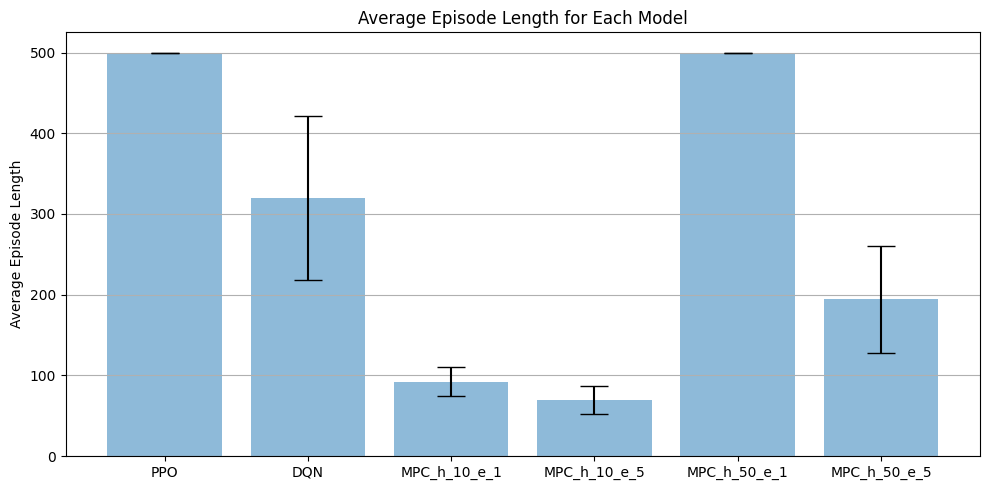

In [ ]:
fig, ax = plt.subplots()
# Set figure size
fig.set_size_inches(10, 5)
models = ["PPO", "DQN", "MPC_h_10_e_1", "MPC_h_10_e_5", "MPC_h_50_e_1", "MPC_h_50_e_5"]
means = [ppo_mean, dqn_mean, mpc_mean_h_10_e_1, mpc_mean_h_10_e_5, mpc_mean_h_50_e_1, mpc_mean_h_50_e_5]
stds = [ppo_std, dqn_std, mpc_std_h_10_e_1, mpc_std_h_10_e_5, mpc_std_h_50_e_1, mpc_std_h_50_e_5]

ax.bar(models, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Episode Length')
ax.set_title('Average Episode Length for Each Model')
ax.yaxis.grid(True)
plt.tight_layout()
plt.savefig("Results/average_episode_lengths.png")

